In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Pavlovic, Mr. Stefo",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
size_train = len(train_data)
dataset = pd.concat([train_data, test_data]).reset_index(drop=True)

In [4]:
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# EDA

### Age

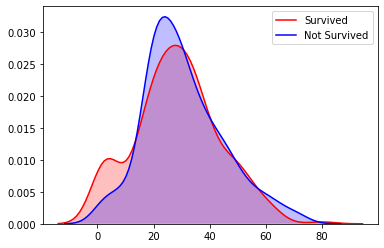

In [5]:
ax = sns.kdeplot(train_data.loc[train_data['Survived']==True, 'Age'], shade=True, color='r')
ax = sns.kdeplot(train_data.loc[train_data['Survived']==False, 'Age'], shade=True, color='b', ax=ax)
ax_legend = ax.legend(['Survived', 'Not Survived'])

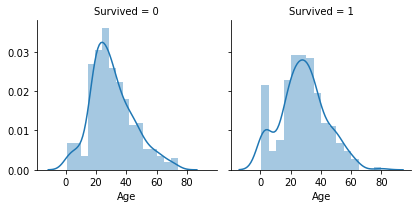

In [6]:
g = sns.FacetGrid(data=train_data, col='Survived')
g = g.map(sns.distplot, 'Age')

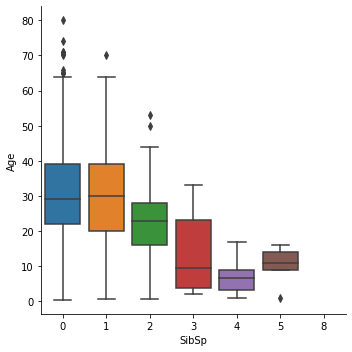

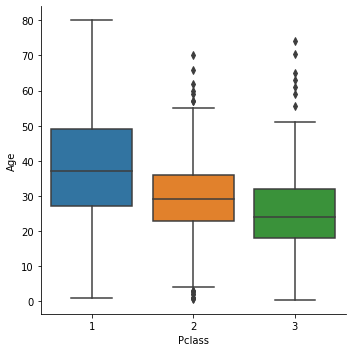

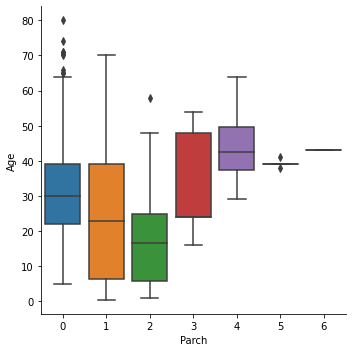

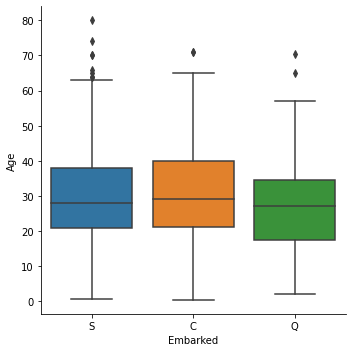

In [7]:
for f in ['SibSp', 'Pclass', 'Parch', 'Embarked']:
    sns.catplot(x=f, y='Age', data=train_data, kind='box')

### Fare

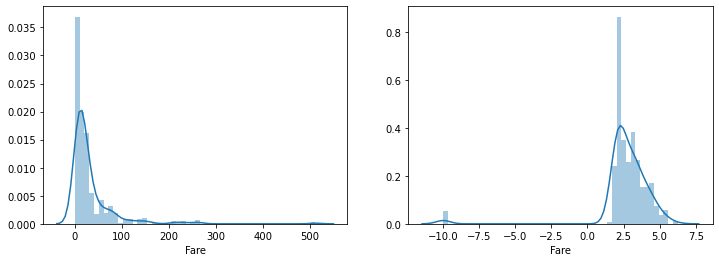

In [8]:
fig = plt.figure(figsize=[12, 4])
axes = fig.subplots(1, 2)
ax = sns.distplot(train_data['Fare'], ax=axes[0])
ax = sns.distplot(train_data['Fare'].map(lambda x: np.log(x) if x > 0 else -10), ax=axes[1])

### Pclass

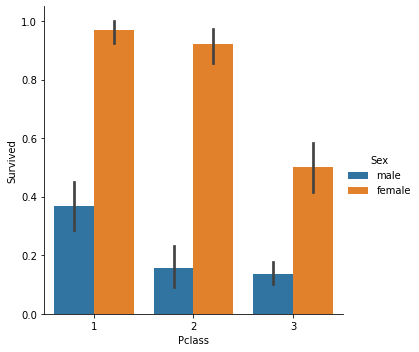

In [9]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train_data, kind='bar')

### Embarked

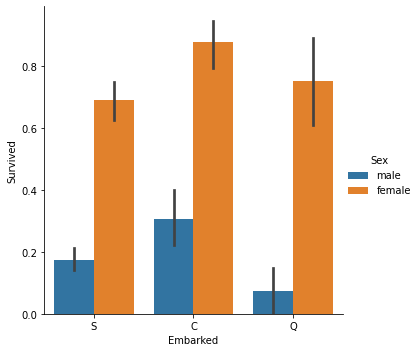

In [10]:
g = sns.catplot(x='Embarked', y='Survived', hue='Sex', data=train_data, kind='bar')

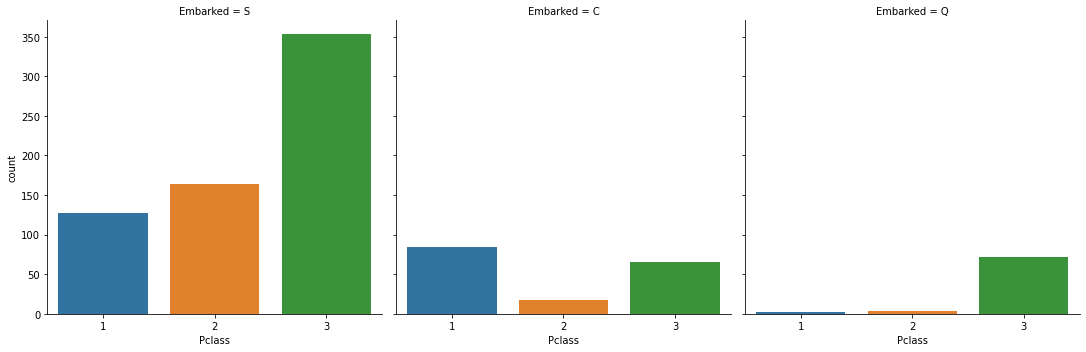

In [11]:
sns.catplot(x='Pclass', col='Embarked', data=train_data, kind='count')

### Family

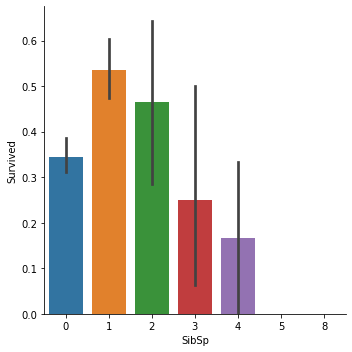

In [12]:
sns.catplot(x='SibSp', y='Survived', data=train_data, kind='bar')

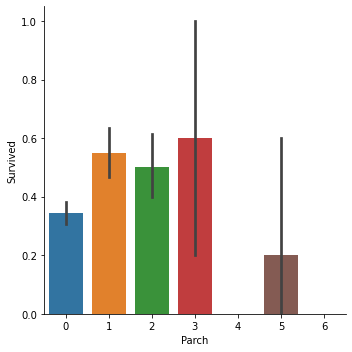

In [13]:
sns.catplot(x='Parch', y='Survived', data=train_data, kind='bar')

### Sex

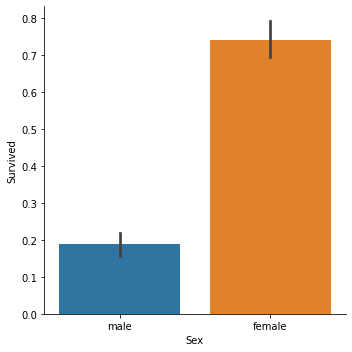

In [14]:
sns.catplot(x='Sex', y='Survived', data=train_data, kind='bar')

## Data processing

In [15]:
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [16]:
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x > 0 else -5)
dataset['Embarked'].fillna('S', inplace=True)

In [17]:
age_nan_idx = dataset.loc[dataset['Age'].isna()].index
for idx in age_nan_idx:
    dataset.loc[idx, 'Age'] = dataset.loc[(dataset['Pclass'] == dataset.loc[idx, 'Pclass']) & (dataset['Embarked'] == dataset.loc[idx, 'Embarked']), 'Age'].median()

In [18]:
dataset['Cabin'] = dataset['Cabin'].fillna('X').map(lambda x: x[0])

In [19]:
dataset['Ticket'] = dataset['Ticket'].str.extract('(^[A-Z]+)').fillna('XXX')

In [20]:
dataset['Title'] = dataset['Name'].str.extract(r' ([A-Za-z]+)\.')

In [21]:
title2val = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3}
dataset['Title'] = dataset['Title'].map(lambda x: title2val[x] if x in title2val.keys() else 4)

In [22]:
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

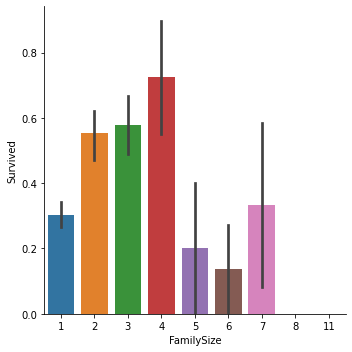

In [23]:
sns.catplot(x='FamilySize', y='Survived', kind='bar', data=dataset)
dataset['Single'] = (dataset['FamilySize'] == 1).astype(np.int)
dataset['SmallFam'] = ((dataset['FamilySize'] > 1) & (dataset['FamilySize'] < 4)).astype(np.int)
dataset['MidFam'] = (dataset['FamilySize'] == 4).astype(np.int)
dataset['LargeFam'] = (dataset['FamilySize'] > 4).astype(np.int)

In [24]:
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')
dataset['Sex'] = (dataset['Sex'] == 'male').astype(np.int)
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='Tk')
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cb')
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Eb')
dataset = pd.get_dummies(dataset, columns=['Title'], prefix='Tt')
dataset.drop(['Name'], axis=1, inplace=True)

In [25]:
dataset.head(10)

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Single,SmallFam,...,Cb_T,Cb_X,Eb_C,Eb_Q,Eb_S,Tt_0,Tt_1,Tt_2,Tt_3,Tt_4
0,1,0.0,1,22.0,1,0,1.981001,2,0,1,...,0,1,0,0,1,1,0,0,0,0
1,2,1.0,0,38.0,1,0,4.266662,2,0,1,...,0,0,1,0,0,0,0,1,0,0
2,3,1.0,0,26.0,0,0,2.070022,1,1,0,...,0,1,0,0,1,0,1,0,0,0
3,4,1.0,0,35.0,1,0,3.972177,2,0,1,...,0,0,0,0,1,0,0,1,0,0
4,5,0.0,1,35.0,0,0,2.085672,1,1,0,...,0,1,0,0,1,1,0,0,0,0
5,6,0.0,1,24.0,0,0,2.135148,1,1,0,...,0,1,0,1,0,1,0,0,0,0
6,7,0.0,1,54.0,0,0,3.948596,1,1,0,...,0,0,0,0,1,1,0,0,0,0
7,8,0.0,1,2.0,3,1,3.048088,5,0,0,...,0,1,0,0,1,0,0,0,1,0
8,9,1.0,0,27.0,0,2,2.409941,3,0,1,...,0,1,0,0,1,0,0,1,0,0
9,10,1.0,0,14.0,1,0,3.403555,2,0,1,...,0,1,1,0,0,0,0,1,0,0


## Start training

In [26]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

In [27]:
y = dataset.iloc[:size_train]['Survived']
X = dataset.iloc[:size_train].drop(columns=['Survived', 'PassengerId'], axis=1)
X_test = dataset.iloc[size_train:].drop(columns=['Survived', 'PassengerId'], axis=1)

In [28]:
clfs = []
random_state = 7
clfs.append(RandomForestClassifier(random_state=random_state))
clfs.append(AdaBoostClassifier(random_state=random_state))
clfs.append(GradientBoostingClassifier(random_state=random_state))
clfs.append(DecisionTreeClassifier(random_state=random_state))
clfs.append(ExtraTreeClassifier(random_state=random_state))
clfs.append(LogisticRegression(random_state=random_state))
clfs.append(SVC(random_state=random_state))
clfs.append(MLPClassifier(random_state=random_state))
clfs.append(LinearDiscriminantAnalysis())

clfs_names = ['RF', 'AdaBoost', 'GB', 'DT', 'ExtraTree', 'LR', 'SVC', 'MLP', 'LDA']
clfs_scores = []
kfold = StratifiedKFold(n_splits=10)
for clf in clfs:
    clfs_scores.append(cross_val_score(clf, X, y, scoring='accuracy', cv=kfold, n_jobs=-1, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

,0
SVC,0.725069
ExtraTree,0.787965
DT,0.796904
AdaBoost,0.818202
RF,0.818227
LDA,0.829413
MLP,0.829426
LR,0.830549
GB,0.835056


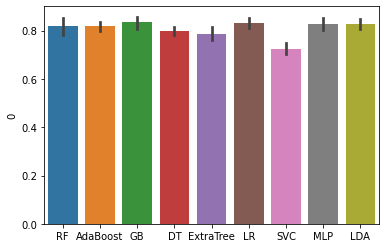

In [29]:
cv_scores = pd.DataFrame({k: v for k, v in zip(clfs_names, clfs_scores)}).unstack().to_frame()
sns.barplot(x=cv_scores.index.get_level_values(0), y=cv_scores[0])
cv_scores.groupby(cv_scores.index.get_level_values(0)).mean().sort_values(by=0)

In [31]:
clf = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [100,200,300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1],}
gsc_gb = GridSearchCV(clf, gb_param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_gb.fit(X, y)
gb_best = gsc_gb.best_estimator_
gb_best_score = gsc_gb.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.7min finished


In [33]:
clf = LogisticRegression()
param_grid = {'penalty': ['l2', 'l1'],
              'C': [1e-2, 1e-1, 1., 10., 100.]}
gsc_lr = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_lr.fit(X, y)
lr_best = gsc_lr.best_estimator_
lr_best_score = gsc_lr.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


In [34]:
clf = MLPClassifier()
param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'learning_rate_init': [1e-2, 1e-3, 1e-4]}
gsc_nn = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_nn.fit(X, y)
nn_best = gsc_nn.best_estimator_
nn_best_score = gsc_nn.best_score_

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  5.1min finished


In [35]:
clf = LinearDiscriminantAnalysis()
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': [None, 'auto']}
gsc_lda = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_lda.fit(X, y)
lda_best = gsc_lda.best_estimator_
lda_best_score = gsc_lda.best_score_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished


In [37]:
clf = RandomForestClassifier()
param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}
gsc_rf = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_rf.fit(X, y)
rf_best = gsc_rf.best_estimator_
rf_best_score = gsc_rf.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.8min finished


In [39]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('GB', gb_best), ('LR', lr_best), ('MLP', nn_best), ('LDA', lda_best), ('RF', rf_best)], voting='soft', n_jobs=-1)
vc = vc.fit(X, y)

In [41]:
results = pd.DataFrame({'PassengerId': dataset.iloc[size_train:]['PassengerId'], 'Survived': vc.predict(X_test).astype(np.int)})
results.to_csv('submission_0804_ensemble.csv', index=False)

In [46]:
rf_best_score

0.8372908863920099